# Load libraries

In [1]:
import pandas as pd
from IPython.display import display

# EDA

In [2]:
train_df = pd.read_csv("../dataset/train.tsv", sep="\t")
test_df = pd.read_csv("../dataset/train.tsv", sep="\t")

In [3]:
display("Train dataframe info")
display(train_df.info(verbose=True))
display("Test dataframe info")
display(test_df.info(verbose=True))

'Train dataframe info'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5758 non-null   object
 1   is_fake  5758 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.1+ KB


None

'Test dataframe info'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5758 non-null   object
 1   is_fake  5758 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.1+ KB


None

In [4]:
display(train_df['is_fake'].value_counts())
display(test_df['is_fake'].value_counts())

1    2879
0    2879
Name: is_fake, dtype: int64

1    2879
0    2879
Name: is_fake, dtype: int64

In [5]:
print(train_df['title'].isna().sum())
print(test_df['title'].isna().sum())

0
0


Выводы - датасет полностью сбалансирован. Тест и траин не имеют дизбаланс классов, а также нан значений. Теперь подробнее исследуем тренировочный датасет

Для 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/stranger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'Plots for column title'

<ipython-input-6-647ada11164e>:57: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axes = grouped.apply(lambda df_p: df_p[text_column].str.split().map(lambda x: len(x))).hist(**hist_params, ax=ax,


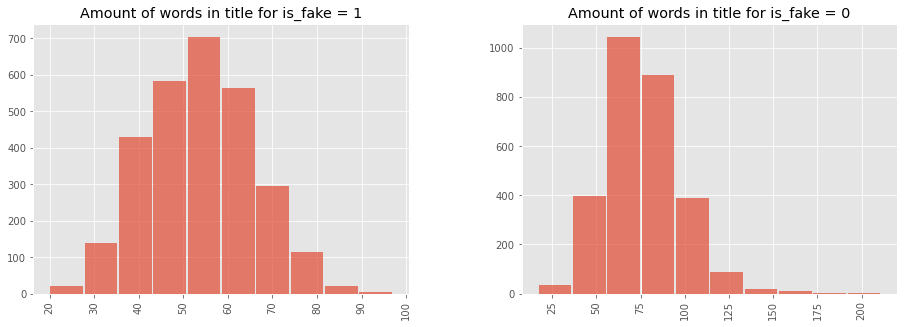

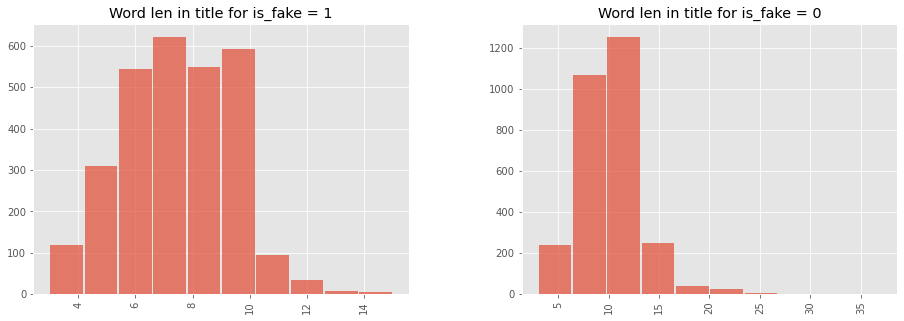

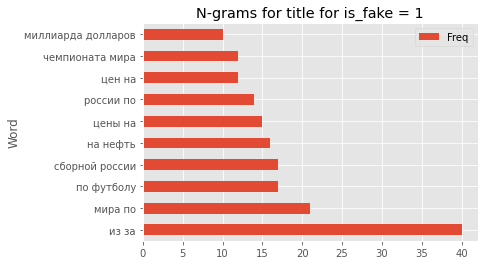

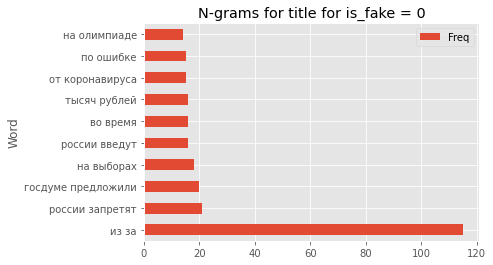

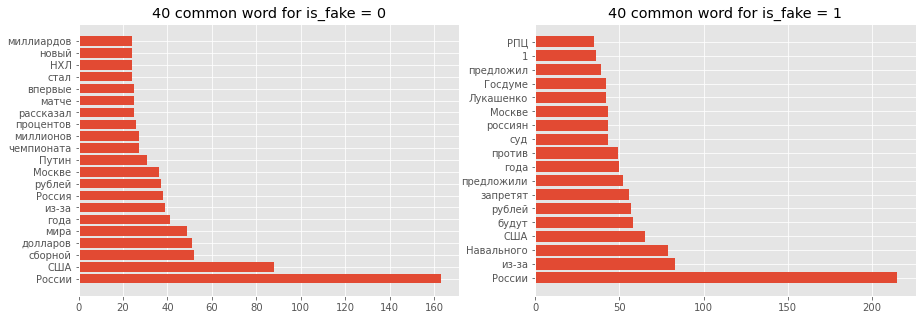

In [6]:
from typing import List
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
plt.style.use('ggplot')
nltk.download('stopwords')

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [[word, sum_words[0, idx]]
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return pd.DataFrame(words_freq[:10], columns=["Word", "Freq"])


def get_words(df: pd.DataFrame, ):
    corpus = []
    for title in df.str.split():
        for word in title:
            corpus.append(word)
    counter = Counter(corpus)
    most = counter.most_common()
    x = []
    y = []
    for word, count in most[:40]:
        if word.lower() not in stopwords.words("russian"):
            x.append(word)
            y.append(count)
    return x, y

def generic_nlp_eda(df: pd.DataFrame, text_columns: List[str], target_colum: str):
    targets = df[target_colum].unique()
    hist_params = dict(figsize=(15, 5), grid=True, rwidth=0.95, alpha=0.7)
    for text_column in text_columns:
        display(f"Plots for column {text_column}")
        grouped = df.groupby(target_colum)
        plot_sent_len(grouped, hist_params, target_colum, targets, text_column)
        plot_amount_of_words(grouped, hist_params, target_colum, targets, text_column)
        axes = grouped.apply(lambda x: get_top_ngram(x[text_column], 2)) \
        .reset_index().drop(columns=["level_1"]).groupby(target_colum).plot.barh(x='Word', y='Freq')
        for i, ax in zip(targets, axes):
            ax.set_title(f"N-grams for {text_column} for {target_colum} = {i}")
        df_ = grouped.apply(lambda x : get_words(x[text_column]))
        fig, axes = plt.subplots(ncols=len(targets), figsize=hist_params['figsize'])
        for i, (index, (y, x)) in enumerate(df_.iteritems()):
            axes[i].barh(width=x, y=y)
            axes[i].set_title(f"40 common word for {target_colum} = {index}")
        plt.show()


def plot_amount_of_words(grouped, hist_params, target_colum, targets, text_column):
    axes = grouped.apply(lambda df_p: df_p[text_column].str.split().map(lambda x: len(x))).hist(**hist_params,
                                                                                                by=target_colum)
    for i, ax in zip(targets, axes):
        ax.set_title(f"Word len in {text_column} for {target_colum} = {i}")


def plot_sent_len(grouped, hist_params, target_colum, targets, text_column):
    axes = grouped.apply(lambda df_p: df_p[text_column].str.len()).hist(**hist_params, by=target_colum)
    for i, ax in zip(targets, axes):
        ax.set_title(f"Amount of words in {text_column} for {target_colum} = {i}")


generic_nlp_eda(train_df, ['title'], 'is_fake')

In [7]:
# есть ли знаки пунктуаци
import string
train_df['title'].str.findall('[{}]'.format(string.punctuation)).explode().dropna().unique()

array([':', ',', '-', '&', '*', '.', '%', '/', '?', '!', '+', '(', ')',
       '_', '#', ';', '$', '`'], dtype=object)

<AxesSubplot:xlabel='Type'>

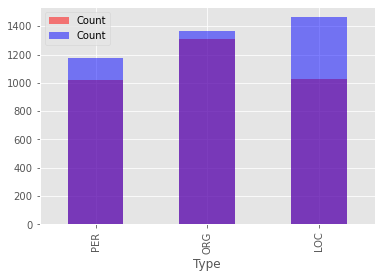

In [34]:
from slovnet import NER
from navec import Navec
navec = Navec.load("../slovnet/navec_news_v1_1B_250K_300d_100q.tar")
ner = NER.load("../slovnet/slovnet_ner_news_v1.tar")
ner.navec(navec)
from collections import Counter
def get_ner(ser : pd.Series):
    c = Counter()
    for text in ser:
       for span in ner(text).spans:
           c[span.type] += 1
    return pd.DataFrame.from_dict({"Type" : c.keys(), "Count" : c.values()})
ax = get_ner(train_df[train_df.is_fake == 0]['title']).plot.bar(x='Type',color="red", alpha=0.5)
get_ner(train_df[train_df.is_fake == 1]['title']).plot.bar(x='Type', ax=ax, color="blue", alpha=0.5)